# Classificação Numérica - Rede Neural

In [3]:
# instalando bibliotecas
%pip install torch
%pip install torchvision
%pip install matplotlib
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Inteli\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Inteli\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Inteli\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Inteli\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [5]:
# importando bibliotecas
import numpy as pd
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt 
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

## Convertendo dados - Tensor

Tensor é como uma matriz, mas não existe um limite de dimensões, podendo estar entre 0 a n. A biblioteca transforma os dados em tensor, por isso iremos realizar a transformação

In [7]:

import torch
from torchvision import datasets, transforms
# definindo a imagem para tensor
transform = transforms.ToTensor()

# treino do dataset
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
# pegar os dados por parte
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# teste do dataset
testset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
# pegar os dados por parte
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Conferindo dados

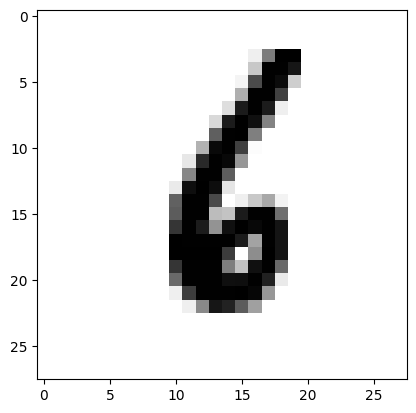

In [11]:
# abrir um dos itens do dataset para visualizar formato
dataiter = iter(trainloader)
img, etiqueta = next(dataiter)
plt.imshow(img[0].numpy().squeeze(), cmap='gray_r')


In [12]:
# analisando a dimensao do tensor imagem e tensor etiqueta
# 1 = intensidade do preto em cada pixel
# 28 = altura da imagem
# 28 = largura da imagem
print(img[0].shape)

# etique nao possui dimensao por ser um escalar
print(etiqueta[0].shape)

torch.Size([1, 28, 28])
torch.Size([])
